# Data ingestion and transformation notebook

This notebook uses the data ingestion standard and run the transformations and feature engineering.

In [1]:
import json
import numpy as np
import pandas as pd
import os
import zipfile
from zipfile import ZipFile
from datetime import datetime, date
import time
import requests
from copy import deepcopy

In [2]:
%reload_ext autoreload
%autoreload 2
main_time_counter = time.time()

In [3]:
# Helper functions for feature engineering:

def decode_stacked_json(stacked_json_string, pos=0, decoder=json.JSONDecoder()):
    """Yield multiple JSON objects and restart parsing from the previous position
    Input must be of the form: {'key1': value1, 'key2': value2}{'key3': value3, 'key4': value4"""
    while True:
        try:
            json_object, pos = decoder.raw_decode(stacked_json_string, pos)
        except json.JSONDecodeError:
            break
        yield json_object
       
        
def after_wake_exercise(class_5min,bedtime_end):
    """returns the number of minutes with medium to high MET scores 
    within the first 3 hours of wake-time as a proxy for whether or not exercise 
    occurs after waking up"""
    if isinstance(class_5min,float) or isinstance(bedtime_end, float):
        return np.nan
    else:
        #convert the str integer into a list of integers
        class_5min_list = list(map(int, class_5min))
        #--take the timestamp from the datetime string, extracts hh:mm data, and converts to a number--#
        wake_hr_min = int(''.join(bedtime_end.split('T')[1][0:5].split(':')))
        #---calculate minutes lapsed since 4am and wake up time---#
        #---rescale minutes into 5 minute intervals to find the number of elements at which to offset class_5min--#
        offset = int(((wake_hr_min - 400)/100)*(60/5))

        #subset observations between wake up and 3 hrs post wake up (24*5=120 min)
        morning_obs = class_5min_list[offset:offset+36]

        #tally total minutes spent in medium to high intensity exercise (3-4)
        total_min = sum([1 for obs in morning_obs if obs >=3])*5
        return total_min


def before_sleep_exercise(class_5min,bedtime_start):
    """returns the number of minutes with medium to high MET scores 
    within the last 3 hours of wake-time as a proxy for whether or not exercise 
    occurs in the evening close to bedtime"""
    if isinstance(class_5min,float) or isinstance(bedtime_start, float):
        return np.nan
    else:
        #convert the str integer into a list of integers
        class_5min_list = list(map(int, class_5min))
        #--take the timestamp from the datetime string, extracts hh:mm data, and converts to a number--#
        sleep_hr_min = int(''.join(bedtime_start.split('T')[1][0:5].split(':')))
        #---calculate minutes lapsed since 4am and wake up time---#
        #---rescale minutes into 5 minute intervals to find the number of elements at which to offset class_5min--#
        offset = int(((sleep_hr_min - 400)/100)*(60/5))

        #subset observations 3 hours before sleep time
        evening_obs = class_5min_list[offset-36:offset]

        #tally total minutes spent in medium to high intensity exercise (3-4)
        total_min = sum([1 for obs in evening_obs if obs >=3])*5
        return total_min


def noon_exercise(class_5min):
    """returns the number of minutes with medium to high MET scores 
    between noon and two local time"""
    if isinstance(class_5min,float):
        return np.nan
    else:
        #convert the str integer into a list of integers
        class_5min_list = list(map(int, class_5min))

        #---calculate minutes lapsed since 4am and 12 (8*12 (5min intervasl in an hr)---#

        offset = 96

        #subset observations between noon and 2 pm
        noon_obs = class_5min_list[offset:offset+24]

        #tally total minutes spent in medium to high intensity exercise (3-4)
        total_min = sum([1 for obs in noon_obs if obs >=3])*5
        return total_min
 
    
def evening_exercise(class_5min):
    """returns the number of minutes with medium to high MET scores 
    between noon and two local time"""
    if isinstance(class_5min, float):
        return np.nan
    else:
        #convert the str integer into a list of integers
        class_5min_list = list(map(int, class_5min))

        #---calculate minutes lapsed since 4am and 5pm (13*12) --there are 12 5min intervasl in an hr---#

        offset = 156

        #subset observations between 5pm and 7 pm post wake up
        eve_obs = class_5min_list[offset:offset+24]

        #tally total minutes spent in medium to high intensity exercise (3-4)
        total_min = sum([1 for obs in eve_obs if obs >=3])*5
        return total_min


def after_midnight(timestamp_str):
    """indicator for whether or not bedtime started after midnight (in early am hours)"""
    try:
        day, hour = timestamp_str.split('T')
        hr = int(hour[0:2]) #extract hr from timestamp
        if 0 <= hr < 6:
            return 1
        else:
            return 0
    except:
        return np.nan

def age_bin(e):
    """Bins: 20s, 30s, 40s, and 50s +"""
    if  20 <= e < 30:
        return "20s"
    elif 30 <= e < 40:
        return "30s"
    elif 40 <= e < 50:
        return "40s"
    elif e > 50:
        return "50s plus"
    else:
        return np.nan
   
    
def height_bin(e):
    """Bins: 0, 150, 160, 170, 180, 190. In centimeters """
    if  0 < e < 150:
        return "less than 150 cm"
    elif 150 <= e <= 160:
        return "150s"
    elif 160 <= e <= 170:
        return "160s"
    elif 170 <= e <= 180:
        return "170s"
    elif 180 <= e <= 190:
        return "180s"
    elif e > 190:
        return "greater than 190 cm"
    else:
        return np.nan
    
    
def weight_bin(e):
    """Bins: 0, 65, 80, 95. In kilograms"""
    if  0 < e <=65:
        return "less than 65 kg"
    elif 65 <= e <= 80:
        return "65 to 80 kg"
    elif 80 <= e <= 95:
        return "80 to 95 kg"
    elif e > 95:
        return "more than 95 kg"
    else:
        return np.nan


def period_over_period(dataframe,usrid,date_col, metric_cols,days_offset):
    """for each datetime in the dataframe's date column, computes the metric column's
    difference from the period days prior:
    returns WoW differences with the corresponding userid and datetime as a tuple"""
    #--first recorded observation date + days_offset
    init_date = min(dataframe[date_col]) + pd.DateOffset(days_offset)
    pop_list = []
    for dt in dataframe[date_col]:
        if dt < init_date: # won't have 7 days prior for the first 7 observations so flag as np.nan
            pop_list.append([usrid,dt]+[np.nan for i in np.arange(len(metric_cols))])
        else:
            try: #---need to account for missing dates
                pop_diff_list = []
                for metric in metric_cols:
                    #grab the value from the prior 7(or n) days -- need to index on 0 since values returns array of array
                    prd_prior = dataframe[dataframe[date_col] == dt + pd.DateOffset(-days_offset)][metric].values[0]
                    #grab the current value
                    prd_current = dataframe[dataframe[date_col] == dt][metric].values[0]
                    #take the diff - list of differences
                    try:
                        pop_diff = (prd_current/prd_prior)-1
                    except ZeroDivisionError: #1 if prior period was 0 (basically capping at 100% increase)
                        pop_diff = 1
                   
                    pop_diff_list.append(pop_diff)
                    
                pop_list.append([usrid,dt]+[i for i in pop_diff_list])
            except:
                #---if missing dates then use nan values
                pop_list.append([usrid,dt]+[np.nan for i in np.arange(len(metric_cols))])

    return pop_list

In [4]:
full_path = 'data_ingestion/{}'.format(date.today().strftime('%d%m%Y'))
os.makedirs(full_path, exist_ok=True)

# create a simple "log file" on the log ingestion directory. Can be helpful to debug and later on for feature monitoring.
log_file = open(full_path + '/log.txt', 'a+')
log_file.write(time.asctime() + ' - Starting data ingestion process\n')

# if a data file exists, load it, otherwise, create the directory, download a new one and load the DFs:
if not os.path.isfile(full_path + '/raw_dataset.zip'):    
    start = time.time() # time the data ingestion from Memento
    log_file.write(time.asctime() + ' - Day file not found. Starting data download\n')
    
    # try: 
    ACCESS_TOKEN = ##ENVIRONMENT VARIABLE HERE##
    headers = {'Authorization': 'Bearer ' + ACCESS_TOKEN }
    URL = "https://api.mementolabs.io/data/dataset"
    # changed this code to deal with streaming json from 10/20/2019 on. Must double check if this will be the final 
    # format
    data = requests.get(URL, headers=headers).content.decode(encoding='utf-8')

    # save the raw data to disk as zip it to allow re-processing without new download
    zip_file = full_path + '/raw_dataset.zip'
    zipObj = ZipFile(zip_file, 'w', compression=zipfile.ZIP_DEFLATED)
    zipObj.writestr('raw_dataset.txt', data)
    zipObj.close()

    # print('total run time:',time.time() - start)
    log_file.write(time.asctime() + ' - JSON File downloaded and saved. Time: ' + f'{(time.time() - start):.1f}' + ' secs.\n')
    

In [5]:
# define intermediate data frames:
users = pd.DataFrame()
sleep = pd.DataFrame()
readiness = pd.DataFrame()
activity = pd.DataFrame()
experiments = pd.DataFrame()

start = time.time()
raw_data = str(zipfile.ZipFile(full_path + '/raw_dataset.zip').read('raw_dataset.txt'), encoding='utf-8')
log_file.write(time.asctime() + ' - raw data file loaded. Time: ' + f'{(time.time() - start):.1f}' + ' secs.\n')

start = time.time()
log_file.write(time.asctime() + ' - creating feature space\n')

active_user_counter = 0

for user_json in decode_stacked_json(raw_data):
    # in the stacked json file, each json object corresponds to all data of one user. So here I will perform all 
    # feature transformation that are user-dependent before I append the whole user data to a final data frame.
    user_user = pd.DataFrame.from_records([user_json['userInfo']['userInfo']])
    
    try: # user signup date may be useful to define if a user model is relevant or not:
        user_user['signupDate'] = pd.to_datetime(user_json['signupDate'])
    except KeyError:
        user_user['signupDate'] = np.nan
        
    # one hot encode gender data:
    try:
        user_user['gender'] = np.where(user_user['gender'] == 'male', True, False)
    except KeyError:
        user_user['gender'] = np.nan
    
    user_user.rename(columns={'gender':'is_male'}, inplace=True)
    
    try:
        user_user['age'] = user_user['age']
    except KeyError:
        user_user['age'] = np.nan
        
    try:
        user_user['height'] = user_user['height']
    except KeyError:
        user_user['height'] = np.nan
    
    try:
        user_user['weight'] = user_user['weight']
    except KeyError:
        user_user['weight'] = np.nan
    
    # send to a final users data frame:
    users = users.append(user_user)
    
    # skip users without sleep records (strictly experiment users, or users of other hardware)
    if len(user_json['sleep']) == 0: continue
    active_user_counter += 1
    
    # unpack data for each user in a specific data frame
    user_sleep = pd.DataFrame.from_records([i for i in user_json['sleep']])
    user_readiness = pd.DataFrame.from_records([i for i in user_json['readiness']])
    user_activity = pd.DataFrame.from_records([i for i in user_json['activity']])
    
    # each DF has a `score` feature. Renaming to avoid later confusion:
    user_sleep.rename(columns = {'score':'sleep_score'}, inplace=True)
    user_activity.rename(columns = {'score':'activity_score'}, inplace=True)
    user_readiness.rename(columns = {'score':'readiness_score'}, inplace=True)

    #### ---------- SLEEP FEATURES ----------- ####
    # sleep features normalizing and transformations:
    user_sleep['awake_norm'] = user_sleep['awake']/user_sleep['duration']
    user_sleep['deep_norm'] = user_sleep['deep']/user_sleep['duration']
    user_sleep['light_norm'] = user_sleep['light']/user_sleep['duration']
    user_sleep['onset_latency_norm'] = user_sleep['onset_latency']/user_sleep['duration']
    user_sleep['rem_norm'] = user_sleep['rem']/user_sleep['duration']
    user_sleep['restless_norm'] = user_sleep['light']/100

    # bins for sleep score to Shiraz's models:
    bins = [0, 75, 85, 100]
    names = ['fair', 'good', 'greate']
    user_sleep['good_sleep'] = pd.cut(user_sleep['sleep_score'], bins=bins, labels=names)

    # creating new sleep features:
    user_sleep['summary_date'] = pd.to_datetime(user_sleep['summary_date'])
    user_sleep['user_id'] = user_user['user_id'][0]
    user_sleep['user_date'] = user_sleep['user_id'] + '|' + user_sleep['summary_date'].astype('str')

    user_sleep.set_index('summary_date', inplace = True, drop=False)

    # build D - 1 and D - 2 scores:
    user_sleep['sleep_score_D-1'] = user_sleep['sleep_score'].shift()[user_sleep.index.shift(1,freq='1D')]
    user_sleep['sleep_score_D-2'] = user_sleep['sleep_score'].shift()[user_sleep.index.shift(1,freq='2D')]
    user_sleep['deep_D-1'] = user_sleep['deep_norm'].shift()[user_sleep.index.shift(1,freq='1D')]
    user_sleep['deep_D-2'] = user_sleep['deep_norm'].shift()[user_sleep.index.shift(1,freq='2D')]
    user_sleep['rem_D-1'] = user_sleep['rem_norm'].shift()[user_sleep.index.shift(1,freq='1D')]
    user_sleep['rem_D-2'] = user_sleep['rem_norm'].shift()[user_sleep.index.shift(1,freq='2D')]

    # build 7, 14, and 21 rolling average scores:
    user_sleep['rol_sleep_score_7d'] = pd.DataFrame.rolling(user_sleep['sleep_score'].shift(1, freq='1D'),
                                                      window=7, min_periods=3).mean()
    # shifted 7 day score rolled feature. This is target feature to predict your average 7 days ahead
    user_sleep['avg_sleep_score_next_week'] = user_sleep['rol_sleep_score_7d'].shift(-1,freq='7D')
    
    user_sleep['rol_sleep_score_14d'] = pd.DataFrame.rolling(user_sleep['sleep_score'].shift(1, freq='1D'),
                                                      window=14, min_periods=10).mean()
    user_sleep['rol_sleep_score_21d'] = pd.DataFrame.rolling(user_sleep['sleep_score'].shift(1, freq='1D'),
                                                      window=21, min_periods=17).mean()
    
    # build other 7-day rolling features for peter's models later:
    user_sleep['rol_bedtime_end_delta_7d'] = pd.DataFrame.rolling(user_sleep['bedtime_end_delta'].shift(1, freq='1D'),
                                                            window=7, min_periods=3).mean()
    user_sleep['rol_bedtime_start_delta_7d'] = pd.DataFrame.rolling(user_sleep['bedtime_start_delta'].shift(1, freq='1D'),
                                                                    window=7, min_periods=3).mean()    
    
    # build is_traveling
    user_sleep['is_traveling'] = np.where(user_sleep['timezone'] == 
                                                    user_sleep['timezone'].value_counts().idxmax(), False, True)

    # build rol_bedtime_start_21d
    user_sleep['rol_bedtime_start_21d'] = pd.DataFrame.rolling(user_sleep['bedtime_start_delta'].shift(1, freq='1D'),
                                                                 window=21, min_periods=10).mean()

    # build avg_bedtime_start_delta, create dummy variables for deviation (-3, -2, -1, 1, 2, 3)
    user_sleep['rol_bedtime_start_std_21d'] = pd.DataFrame.rolling(user_sleep['bedtime_start_delta'].shift(1, freq='1D'),
                                                                 window=21, min_periods=10).std()

    user_sleep['bedtime_start_dev'] = (user_sleep['bedtime_start_delta'] - user_sleep['rol_bedtime_start_21d'])/\
                                      user_sleep['rol_bedtime_start_std_21d']

    user_sleep['bedtime_start_dev'] = np.where(user_sleep['bedtime_start_dev'] >= 0, 
                                                        np.ceil(user_sleep['bedtime_start_dev']),
                                                        np.floor(user_sleep['bedtime_start_dev']))
    # cap standard deviations to -3 or +3:
    user_sleep['bedtime_start_dev'] = np.where(user_sleep['bedtime_start_dev'] <= -3,-3, user_sleep['bedtime_start_dev'])

    user_sleep['bedtime_start_dev'] = np.where(user_sleep['bedtime_start_dev'] >= 3,3,
                                                        user_sleep['bedtime_start_dev'])

    user_sleep = pd.get_dummies(user_sleep, columns=['bedtime_start_dev'])

    user_sleep.rename(columns = { 'bedtime_start_dev_-3.0':'bedtime_start_dev-3', 
                                  'bedtime_start_dev_-2.0':'bedtime_start_dev-2', 
                                  'bedtime_start_dev_-1.0': 'bedtime_start_dev-1',
                                  'bedtime_start_dev_1.0': 'bedtime_start_dev+1',
                                  'bedtime_start_dev_2.0': 'bedtime_start_dev+2',
                                  'bedtime_start_dev_3.0': 'bedtime_start_dev+3'},
                                  inplace = True)

    user_sleep.drop(labels = ['rol_bedtime_start_21d','rol_bedtime_start_std_21d'], axis = 1, inplace = True)

    # build avg_bedtime_end_delta, create dummy variables for deviation. (-3, -2, -1, 1, 2, 3)
    user_sleep['rol_bedtime_end_21d'] = pd.DataFrame.rolling(user_sleep['bedtime_end_delta'].shift(1, freq='1D'),
                                                                 window=21, min_periods=10).mean()

    user_sleep['rol_bedtime_end_std_21d'] = pd.DataFrame.rolling(user_sleep['bedtime_end_delta'].shift(1, freq='1D'),
                                                                 window=21, min_periods=10).std()

    user_sleep['bedtime_end_dev'] = (user_sleep['bedtime_end_delta'] - user_sleep['rol_bedtime_end_21d'])/\
                                    user_sleep['rol_bedtime_end_std_21d']

    user_sleep['bedtime_end_dev'] = np.where(user_sleep['bedtime_end_dev'] >= 0, 
                                             np.ceil(user_sleep['bedtime_end_dev']),
                                             np.floor(user_sleep['bedtime_end_dev']))
    # cap standard deviations to -3 or +3:
    user_sleep['bedtime_end_dev'] = np.where(user_sleep['bedtime_end_dev'] <= -3,-3,
                                             user_sleep['bedtime_end_dev'])

    user_sleep['bedtime_end_dev'] = np.where(user_sleep['bedtime_end_dev'] >= 3,3,
                                             user_sleep['bedtime_end_dev'])

    user_sleep = pd.get_dummies(user_sleep, columns=['bedtime_end_dev'])

    user_sleep.rename(columns = {'bedtime_end_dev_-3.0':'bedtime_end_dev-3', 
                                 'bedtime_end_dev_-2.0':'bedtime_end_dev-2', 
                                 'bedtime_end_dev_-1.0': 'bedtime_end_dev-1',
                                 'bedtime_end_dev_1.0': 'bedtime_end_dev+1',
                                 'bedtime_end_dev_2.0': 'bedtime_end_dev+2',
                                 'bedtime_end_dev_3.0': 'bedtime_end_dev+3'},
                                 inplace = True)

    user_sleep.drop(labels = ['rol_bedtime_end_21d','rol_bedtime_end_std_21d'], axis = 1, inplace = True)

    # build avg_duration, create dummy variables for deviation (-3, -2, -1, 1, 2, 3)
    user_sleep['rol_duration_21d'] = pd.DataFrame.rolling(user_sleep['duration'].shift(1, freq='1D'),
                                                                 window=21, min_periods=10).mean()

    user_sleep['rol_duration_std_21d'] = pd.DataFrame.rolling(user_sleep['duration'].shift(1, freq='1D'),
                                                                 window=21, min_periods=10).mean()

    user_sleep['duration_dev'] = (user_sleep['duration'] - user_sleep['rol_duration_21d'])/\
                                 user_sleep['rol_duration_std_21d']

    user_sleep['duration_dev'] = np.where(user_sleep['duration_dev'] >= 0, 
                                          np.ceil(user_sleep['duration_dev']),
                                          np.floor(user_sleep['duration_dev']))

    # cap standard deviations to -3 or +3:
    user_sleep['duration_dev'] = np.where(user_sleep['duration_dev'] <= -3,-3, user_sleep['duration_dev'])

    user_sleep['duration_dev'] = np.where(user_sleep['duration_dev'] >= 3,3, user_sleep['duration_dev'])

    user_sleep = pd.get_dummies(user_sleep, columns=['duration_dev'])

    user_sleep.rename(columns = {'duration_dev_-3.0':'duration_dev-3', 
                              'duration_dev_-2.0':'duration_dev-2', 
                              'duration_dev_-1.0':'duration_dev-1',
                              'duration_dev_1.0': 'duration_dev+1',
                              'duration_dev_2.0': 'duration_dev+2',
                              'duration_dev_3.0': 'duration_dev+3'},
                              inplace = True)

    user_sleep.drop(labels = ['rol_duration_21d','rol_duration_std_21d'], axis = 1, inplace = True)

    # build dummy to day of the week.
    user_sleep['weekday'] = user_sleep['summary_date'].dt.weekday

    # build is_workday
    user_sleep['is_workday'] = np.where(user_sleep['weekday'] < 5, True, False)

    # one-hot encode weekdays
    user_sleep = pd.get_dummies(user_sleep, columns=['weekday'])

    user_sleep.rename(columns = {'weekday_0':'weekday_mon', 
                              'weekday_1':'weekday_tue', 
                              'weekday_2': 'weekday_wed',
                              'weekday_3': 'weekday_thu',
                              'weekday_4': 'weekday_fri',
                              'weekday_5': 'weekday_sat',
                              'weekday_6': 'weekday_sun'}, 
                              inplace = True)

    sleep_vars_to_roll = ['onset_latency','duration','is_traveling','score_disturbances']
    
    for feature in sleep_vars_to_roll :
        user_sleep['rol_' + feature + '_7d'] = pd.DataFrame.rolling(user_sleep[feature].shift(1, freq='1D'),
                                                      window=7, min_periods=3).mean()
    
    
    #---Week-over-Week sleep behavior changes as proxy for sleep routine---#
    user_sleep['rol_onset_latency_7d_WoW'] = user_sleep['rol_onset_latency_7d'].pct_change(periods=7)
    user_sleep['rol_duration_7d_WoW'] = user_sleep['rol_duration_7d'].pct_change(periods=7)
    user_sleep['rol_score_disturbances_7d_WoW'] = user_sleep['rol_score_disturbances_7d'].pct_change(periods=7)
    user_sleep['rol_bedtime_start_delta_7d_WoW'] = user_sleep['rol_bedtime_start_delta_7d'].pct_change(periods=7)
    
    #sleep routine as the mean absolute value of WoW variables
    user_sleep['sleep_routine_score'] = (
    np.absolute(user_sleep['rol_onset_latency_7d_WoW']) + 
    np.absolute(user_sleep['rol_duration_7d_WoW']) +
    np.absolute(user_sleep['rol_score_disturbances_7d_WoW'])+
    np.absolute(user_sleep['rol_bedtime_start_delta_7d_WoW']))/4
    
    user_sleep.set_index('user_date', inplace = True)
    
    sleep = sleep.append(user_sleep)
    
    
    #### ---------- ACTIVITY FEATURES ----------- ####
    # Creating the new activity related features. Because several activity features depends on user info and/or 
    # sleep features, I will add the features needed here:
    user_activity['user_date'] = user_user['user_id'][0] + '|' + user_activity['summary_date'].astype('str')
    
    user_activity['age'] = user_user['age'][0]
    user_activity['height'] = user_user['height'][0]
    user_activity['weight'] = user_user['weight'][0]
    user_activity['is_male'] = user_user['is_male'][0]
 
    user_activity['summary_date'] = pd.to_datetime(user_activity['summary_date'])   
    user_activity = user_activity.merge(user_sleep[['bedtime_start', 'bedtime_end', 'summary_date']], 
                                        on='summary_date', how='left')
    
    user_activity.set_index('summary_date', inplace = True, drop=False)
    
    user_activity['met_min_medium_plus'] = user_activity['met_min_medium'] + \
                                                    user_activity['met_min_high']

    user_activity['age_bin'] = user_activity['age'].apply(age_bin)
    user_activity['height_bin'] = user_activity['height'].apply(height_bin)
    user_activity['weight_bin'] = user_activity['weight'].apply(weight_bin)
    user_activity['sleep_afterMidnight'] = user_activity['bedtime_start'].apply(after_midnight)
    user_activity['afterwake_exercise_min'] = [after_wake_exercise(c,b) for c,b in \
                                               zip(user_activity['class_5min'],
                                                   user_activity['bedtime_end'])]
    user_activity['beforesleep_exercise_min'] = [before_sleep_exercise(c,b) for c,b in \
                                                 zip(user_activity['class_5min'],
                                                     user_activity['bedtime_start'])]
    user_activity['noon_exercise_min'] = user_activity['class_5min'].apply(noon_exercise)
    user_activity['eve_exercise_min'] = user_activity['class_5min'].apply(evening_exercise)
    
    # create activity and sleep variables that will be rolled within a 7 day window
    activity_vars_to_roll = ['cal_total', 'high', 'medium','steps','inactive', 
                             'non_wear', 'activity_score','met_min_medium','sleep_afterMidnight',
                             'met_min_high', 'met_min_medium_plus','score_move_every_hour',
                             'score_stay_active', 'beforesleep_exercise_min',
                             'afterwake_exercise_min','noon_exercise_min', 'eve_exercise_min']

    for feature in activity_vars_to_roll :
        user_activity['rol_' + feature + '_7d'] = pd.DataFrame.rolling(user_activity[feature].shift(1, freq='1D'),
                                                      window=7, min_periods=3).mean()
    
    #---Week-over-Week activity behavior changes as proxy for activity routine---#
    #note; these variables are already recorded on a last 7 day average per API so we didn't need to roll them
    user_activity['score_training_frequency_WoW'] = user_activity['score_training_frequency'].pct_change(periods=7)
    user_activity['score_training_volume_WoW'] = user_activity['score_training_volume'].pct_change(periods=7)
    user_activity['score_meet_daily_targets_WoW'] = user_activity['score_meet_daily_targets'].pct_change(periods=7)
    user_activity['score_recovery_time_WoW'] = user_activity['score_recovery_time'].pct_change(periods=7)
    
    #activity routine as the mean absolute value of WoW variables
    user_activity['activity_routine_score'] = (
    np.absolute(user_activity['score_training_frequency_WoW']) + 
    np.absolute(user_activity['score_training_volume_WoW']) +
    np.absolute(user_activity['score_meet_daily_targets_WoW'])+
    np.absolute(user_activity['score_recovery_time_WoW']))/4
    
    user_activity.set_index('user_date', inplace = True)
    activity = activity.append(user_activity)


    #### ---------- READINESS FEATURES ----------- ####
    # As we are not doing any transformation in the readiness data frame, append directly to the final one:
    user_readiness['user_date'] = user_user['user_id'][0] + '|' + user_readiness['summary_date'].astype('str')
    user_readiness.set_index('user_date', inplace=True)
    readiness = readiness.append(user_readiness)


    #### ---------- EXPERIMENTS FEATURES ----------- ####
    # Sorting the experiment data for the first iteration:
    if len(user_json['previousExperiments']) != 0:
    # for now, only completed experiments are taken. Each feature contains a list of inputs. The unique user ID is 
    # added for later incorporation of this results with the data set.
    # NOTE: we don't have a summary_date here. To get that, unpack the list inside of features 'CheckIns' and get
    # key 'date'.
        user_experiments = pd.DataFrame.from_records([i for i in user_json['previousExperiments']])
        user_experiments['user_id'] = user_user['user_id'][0]

        experiments = experiments.append(user_experiments)

# log the time and main descriptive statistics of the final datasets for data governance purposes
log_file.write(time.asctime() + ' - Feature space created. Time: ' + f'{(time.time() - start):.1f}' + ' secs.\n')
log_file.write(time.asctime() + '     - Total active users: ' + str(active_user_counter) + '\n')
log_file.write(time.asctime() + '     - ACTIVITY data frame shape: ' + str(activity.shape) + '\n')
log_file.write(time.asctime() + '     - SLEEP data frame shape: ' + str(sleep.shape) + '\n')
log_file.write(time.asctime() + '     - READINESS data frame shape: ' + str(readiness.shape) + '\n')
log_file.write(time.asctime() + '     - EXPERIMENTS data frame shape: ' + str(experiments.shape) + '\n')

70

In [6]:
start = time.time()

# Save each DF as a csv file (case needed to work on a single file in teh future
users_file_path = full_path + '/users_data.csv'
sleep_file_path = full_path + '/sleep_data.csv'
readiness_file_path = full_path + '/readiness_data.csv'
activity_file_path = full_path + '/activity_data.csv'
df_gold_file_path = full_path + '/gold.csv'
experiments_file_path = full_path + '/experiments.csv'

users.to_csv(users_file_path, index=None, encoding='utf-8')
sleep.to_csv(sleep_file_path, index_label='user_date', encoding='utf-8')
readiness.to_csv(readiness_file_path, index_label='user_Date', encoding='utf-8')
activity.to_csv(activity_file_path, index_label='user_Date', encoding='utf-8')
experiments.to_csv(experiments_file_path, index=None, encoding='utf-8')

# Drop duplicate columns and merge all dfs in a big "gold" df. Will keep only one of the summary dates (readiness)
# sleep.drop('summary_date', axis=1, inplace=True)
# activity.drop(['bedtime_start', 'bedtime_end', 'summary_date'], axis=1, inplace=True)

# merge all data frames into one
df_gold = sleep.merge(activity, left_index=True, right_index=True)
df_gold = df_gold.merge(readiness, left_index=True, right_index=True)

df_gold.to_csv(df_gold_file_path, index_label='user_date', encoding='utf-8')

log_file.write(time.asctime() + '     - GOLD data frame shape: ' + str(df_gold.shape) + '\n')

# zip all files in a gold_dataset.zip
files = [users_file_path, sleep_file_path, readiness_file_path,
         activity_file_path, df_gold_file_path, experiments_file_path]

files_names = ['users_data.csv', 'sleep_data.csv', 'readiness_data.csv',
         'activity_data.csv', 'gold.csv', 'experiments.csv']

zip_file = full_path + '/gold_dataset.zip'
zipObj = zipfile.ZipFile(zip_file, mode='w')

for i in range(len(files)):
    zipObj.write(files[i], arcname=files_names[i])    

zipObj.close()

# delete unzipped CSVs
for i in range(len(files)):
    os.remove(files[i])
    
log_file.write(time.asctime() + ' - All data frames saved and zipped. Time: ' + f'{(time.time() - start):.1f}' + ' secs.\n')

log_file.write(time.asctime() + ' - Total time spent in the routine: ' + f'{(time.time() - main_time_counter):.1f}' + ' secs.\n')
log_file.write(time.asctime() + ' ##### ----- DATA INGESTION ROUTINE FINALIZED ----- #####\n\n')

log_file.close()



#### Questions for Marcelo

 - should user_sleep['restless_norm'] = user_sleep['light']/100 really be user_sleep['restless_norm'] = user_sleep['light_norm']/100
 
 - do we need to shift by a day in the roll method?
 
 - possibility of incorporating period_over_period function into main code block


### Unzipping and Reading in Gold Dataset

In [7]:
import zipfile
unzip_file_path = full_path + '/unzipped_data'
os.makedirs(unzip_file_path, exist_ok=True)

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(unzip_file_path)

In [4]:
# df_gold = pd.read_csv(unzip_file_path +'/gold.csv',parse_dates = ['summary_date'])
# df_gold['user_id'] = list(pd.Series(df_gold.user_date).apply(lambda x: str(x).split('|')[0]))
# df_gold.head()

#### Reading in from Storage

In [3]:
#file = os.getcwd()+'/⁨data_ingestion⁩/28102019⁩/unzipped_data⁩/gold.csv'
df_gold = pd.read_csv('data_ingestion/03112019/unzipped_data/gold.csv',parse_dates = ['summary_date'])
df_gold['user_id'] = list(pd.Series(df_gold.user_date).apply(lambda x: str(x).split('|')[0]))
df_gold.head()

,user_date,avg_sleep_score_next_week,awake,awake_norm,bedtime_end_x,bedtime_end_delta,bedtime_end_dev+1,bedtime_end_dev+2,bedtime_end_dev+3,bedtime_end_dev-1,...,period_id_y,readiness_score,score_activity_balance,score_previous_day,score_previous_night,score_recovery_index,score_resting_hr,score_sleep_balance,score_temperature,summary_date
0,3GFNJNPROVUFMPSYCY4I2ZHED5LF4IP4|2018-10-11,NaN,4380,0.136961,2018-10-12T12:28:03+01:00,44883,0.0,0.0,0.0,0.0,...,2,83,100,47,65,66,96,96,84,2018-10-11
1,3GFNJNPROVUFMPSYCY4I2ZHED5LF4IP4|2018-10-12,70.571429,6810,0.206364,2018-10-13T12:20:18+02:00,44418,0.0,0.0,0.0,0.0,...,0,75,69,88,53,30,97,87,91,2018-10-12
2,3GFNJNPROVUFMPSYCY4I2ZHED5LF4IP4|2018-10-13,71.142857,5250,0.155694,2018-10-14T12:40:03+02:00,45603,0.0,0.0,0.0,0.0,...,0,80,55,85,71,70,89,92,97,2018-10-13
3,3GFNJNPROVUFMPSYCY4I2ZHED5LF4IP4|2018-10-14,NaN,2610,0.088057,2018-10-15T11:22:02+02:00,40922,0.0,0.0,0.0,0.0,...,1,81,78,90,68,68,89,87,99,2018-10-14
4,3GFNJNPROVUFMPSYCY4I2ZHED5LF4IP4|2018-10-15,NaN,7350,0.247475,2018-10-16T13:55:53+01:00,50153,0.0,0.0,0.0,0.0,...,0,73,74,86,54,80,90,64,90,2018-10-15


### MODELING

In [94]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error,mean_absolute_error,explained_variance_score,median_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
#features to add - routine_score,'is_male','age_bin_20s', 'age_bin_30s','age_bin_40s', 'age_bin_50s plus'
#---------------- 'temperature_deviation','score_meet_daily_targets',

model_columns = ['summary_date','rol_sleep_score_7d','rol_sleep_afterMidnight_7d','rol_onset_latency_7d','rol_duration_7d',
                 'rol_score_disturbances_7d','rol_bedtime_start_delta_7d','rol_cal_total_7d','rol_steps_7d',
                 'rol_met_min_medium_plus_7d','rol_score_move_every_hour_7d', 'rol_score_stay_active_7d', 
                 'rol_beforesleep_exercise_min_7d', 'rol_afterwake_exercise_min_7d','rol_is_traveling_7d',
                 'score_training_frequency', 'score_training_volume','score_meet_daily_targets',
                 'temperature_deviation','is_male','is_workday','avg_sleep_score_next_week',
                 'activity_routine_score','sleep_routine_score','user_id']


mod_df = df_gold.filter(model_columns)


In [15]:
# splitting training and test set by recency
train = mod_df[mod_df['summary_date'] <= pd.Timestamp(2019, 9, 1, 12)]
test = mod_df[mod_df['summary_date'] > pd.Timestamp(2019, 9, 1, 12)]
#-dropping summary date since its not needed
train = train.drop(['summary_date'],axis=1)
test = test.drop(['summary_date'],axis=1)
#dropping NaNs - still need to resolve how we want to handle NAs
train = train.dropna()
test = test.dropna()

In [28]:
import warnings
warnings.filterwarnings('ignore')
#drop summary date from features
features = [f for f in model_columns if f not in {'summary_date','avg_sleep_score_next_week','user_id'}]
rf_regr = RandomForestRegressor()
rf_regr.fit(train[features],train['avg_sleep_score_next_week'])
rf_reg_pred = rf_regr.predict(test[features])

In [29]:
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(rf_regr, random_state=1).fit(test[features], test['avg_sleep_score_next_week'])
eli5.show_weights(perm, feature_names = test[features].columns.tolist())

Weight,Feature
1.1440 ± 0.0575,rol_sleep_score_7d
0.0652 ± 0.0084,rol_score_disturbances_7d
0.0196 ± 0.0040,rol_bedtime_start_delta_7d
0.0151 ± 0.0041,rol_duration_7d
0.0140 ± 0.0028,rol_sleep_afterMidnight_7d
0.0101 ± 0.0030,rol_score_move_every_hour_7d
0.0078 ± 0.0031,rol_afterwake_exercise_min_7d
0.0066 ± 0.0045,rol_cal_total_7d
0.0052 ± 0.0042,rol_score_stay_active_7d
0.0036 ± 0.0009,is_male


In [30]:
#-----RESULTS of Predicting Avg Sleep Score Over Next 7 Days Based on Prior 7 Days--------#
print('R2 of: ',r2_score(test['avg_sleep_score_next_week'], rf_reg_pred))
print('MSE of: ', mean_squared_error(test['avg_sleep_score_next_week'], rf_reg_pred))
print('MAE of: ', mean_absolute_error(test['avg_sleep_score_next_week'], rf_reg_pred))
print('Explained Variance:', explained_variance_score(test['avg_sleep_score_next_week'], rf_reg_pred))
print('Median Absolute Error',median_absolute_error(test['avg_sleep_score_next_week'], rf_reg_pred))

R2 of:  0.7582959501629297
MSE of:  16.03270353302612
MAE of:  3.1209787140662715
Explained Variance: 0.7595986083740558
Median Absolute Error 2.5142857142857196


### RECOMMENDER

In [31]:
#recommender based on disturbances
def recommender(model,user_data,actionable_features):
    base_prediction = model.predict(user_data)[0]
    adj_predictions = []
    for a in actionable_features:
        #reset the copy on each iteration
        user_data_copy = user_data.copy()
        if a in {'rol_bedtime_start_delta_7d','activity_routine_score','sleep_routine_score'}:
            #all features above have an ideal target of 0
            user_data_copy[a] = 0
            adj_prediction = model.predict(user_data_copy)[0]
            if adj_prediction > base_prediction:
                adj_predictions.append([a,adj_prediction])

        elif a in {'rol_score_disturbances_7d','score_training_frequency','score_training_volume'}:
            #all features above have an ideal target of 95+
            user_data_copy[a] = 95
            adj_prediction = model.predict(user_data_copy)[0]
            if adj_prediction > base_prediction:
                adj_predictions.append([a,adj_prediction])
        elif a in {'rol_steps_7d'}:
            #1 mile is approximately 2000 steps (will increment avg by 2000)
            user_data_copy[a] = user_data_copy[a].values[0] + 2000
            adj_prediction = model.predict(user_data_copy)[0]   
            if adj_prediction > base_prediction:
                adj_predictions.append([a,adj_prediction])

        elif a == 'rol_sleep_afterMidnight_7d':
            if user_data_copy[a].values[0] > 0:
                user_data_copy[a] = 0
                adj_prediction = model.predict(user_data_copy)[0]   
                if adj_prediction > base_prediction:
                    adj_predictions.append([a,adj_prediction])
        else:
            if a == 'rol_onset_latency_7d':
                user_data_copy[a] = 900    
                adj_prediction = model.predict(user_data_copy)[0]   
                if adj_prediction > base_prediction:
                    adj_predictions.append([a,adj_prediction])
                    
    return adj_predictions

In [32]:
actionable_features = ['rol_sleep_afterMidnight_7d','rol_onset_latency_7d','rol_score_disturbances_7d',
                       'rol_bedtime_start_delta_7d','rol_cal_total_7d','rol_steps_7d','score_training_frequency',
                       'score_training_volume','activity_routine_score','sleep_routine_score']

In [33]:
#Ed's userID is TE2CPSSWP4QUGFAJQZ5FHITIKPNCCICX
ed_data = mod_df[(mod_df['user_id'] == 'TE2CPSSWP4QUGFAJQZ5FHITIKPNCCICX') & (mod_df['summary_date'] == '2019-10-03')].filter(features)
#uses random forest model

recommender(model = rf_regr,user_data = ed_data,actionable_features = actionable_features)


[['rol_score_disturbances_7d', 75.75714285714287],
 ['rol_steps_7d', 73.17142857142855]]

In [34]:
#actual 7 day average score 
ed_actual = mod_df[(mod_df['user_id'] == 'TE2CPSSWP4QUGFAJQZ5FHITIKPNCCICX') & (mod_df['summary_date'] == '2019-10-03')]\
.filter(['avg_sleep_score_next_week']).values[0]

ed_predicted = rf_regr.predict(ed_data)

print("Ed's actual:",str(ed_actual)," VS Ed's predicted:", str(ed_predicted))

Ed's actual: [74.71428571]  VS Ed's predicted: [72.85714286]


### MODEL COMPARISON VS BASELINE

The prior week's sleep score provides the biggest signal, by far, to next week's sleep score. This is somewhat expected considering much of what could influence sleep quality isn't captured in the data source we're pooling from (i.e. ommitted variable bias/exogenous to the model). For instance age of and number of dependents in the household, medications and/or diseases, income, job status, and other external stress factors aren't accounted for.

What we'd like to see is the 20 feature model to consistently outperform the baseline (prior 7 day sleep score as single feature) model. We can measure performance by mae and/or explained variance.

We can take 20 (would it make sense to make this random or do we think recency is the best sampling tactic) test samples, within a confined recency period, to generate two random forest models - one using the baseline feature and the other using our 20 features

In [90]:
def benchmarker(data_set,variable_set,model, model_evaluator = 'explained_variance_score',
                outcome = 'avg_sleep_score_next_week',test_split_date = pd.Timestamp(2019, 6, 1, 12),
                num_comparisons = 15):
    
    
    #the dataframe we're modeling on
    modeling_dataframe = data_set.filter(variable_set)
    #this is the signal we're comparing the model against
    baseline_feature = 'rol_sleep_score_7d'
    
    features = [f for f in variable_set if f not in {'summary_date','avg_sleep_score_next_week','user_id','avg_sleep_score_next_week_binarized'}]
    
    split_dates = []
    baseline_es = []
    current_es = []

    split_date = test_split_date

    for i in np.arange(num_comparisons):

        #instantiating models
        baseline_mod = model
        current_mod = deepcopy(model)

        #splitting on recency for cross-validation
        train = modeling_dataframe[modeling_dataframe['summary_date'] <= split_date]
        test = modeling_dataframe[modeling_dataframe['summary_date'] > split_date]
        train = train.drop(['summary_date'],axis=1)
        test = test.drop(['summary_date'],axis=1)
        train = train.dropna()
        test = test.dropna()

        #training baseline feature and initial features with random forest model
        baseline_mod.fit(train[baseline_feature].reshape(-1, 1),train[outcome])
        current_mod.fit(train[features],train[outcome])
        baseline_pred = baseline_mod.predict(test[baseline_feature].reshape(-1, 1))
        current_pred = current_mod.predict(test[features])
        
        if model_evaluator == 'explained_variance_score':
            baseline_e = explained_variance_score(test[outcome], baseline_pred)
            current_e = explained_variance_score(test[outcome], current_pred)
            baseline_es.append(baseline_e)
            current_es.append(current_e)
            
        elif model_evaluator == 'median_absolute_error':
            baseline_e = median_absolute_error(test[outcome], baseline_pred)
            current_e = median_absolute_error(test[outcome], current_pred)
            baseline_es.append(baseline_e)
            current_es.append(current_e)
        
        elif model_evaluator == 'mean_absolute_error':
            baseline_e = mean_absolute_error(test[outcome], baseline_pred)
            current_e = mean_absolute_error(test[outcome], current_pred)
            baseline_es.append(baseline_e)
            current_es.append(current_e)
            
        elif model_evaluator == 'accuracy':
            baseline_e = accuracy_score(test[outcome], baseline_pred)
            current_e = accuracy_score(test[outcome], current_pred)
            baseline_es.append(baseline_e)
            current_es.append(current_e)               
        
        else:
            print("model_evaluator isnt accepted")
            
        split_dates.append(split_date)

        #updating split date
        split_date = split_date + pd.DateOffset(days = 7)
        
    comparison_df = pd.DataFrame({'split_date':split_dates,'baseline_score':baseline_es,'model_score':current_es})
    comparison_df_long = pd.melt(comparison_df,id_vars=['split_date'], value_vars=['baseline_score', 'model_score'])
    
    sns.set(style="white", color_codes=True)
    fig, ax = plt.subplots(1,1,figsize=(15,12))
    ax = sns.lineplot(x='split_date', y= 'value',hue = 'variable' , data=comparison_df_long)
    ax.set(xlabel='Split Date', ylabel= model_evaluator)
    
        
    return plt.show()

In [76]:
model_columns = ['summary_date','rol_sleep_score_7d','rol_sleep_afterMidnight_7d','rol_onset_latency_7d','rol_duration_7d',
                 'rol_score_disturbances_7d','rol_bedtime_start_delta_7d','rol_cal_total_7d','rol_steps_7d',
                 'rol_met_min_medium_plus_7d','rol_score_move_every_hour_7d', 'rol_score_stay_active_7d', 
                 'rol_beforesleep_exercise_min_7d', 'rol_afterwake_exercise_min_7d','rol_is_traveling_7d',
                 'score_training_frequency', 'score_training_volume','score_meet_daily_targets',
                 'temperature_deviation','is_male','is_workday','avg_sleep_score_next_week',
                 'activity_routine_score','sleep_routine_score','user_id']

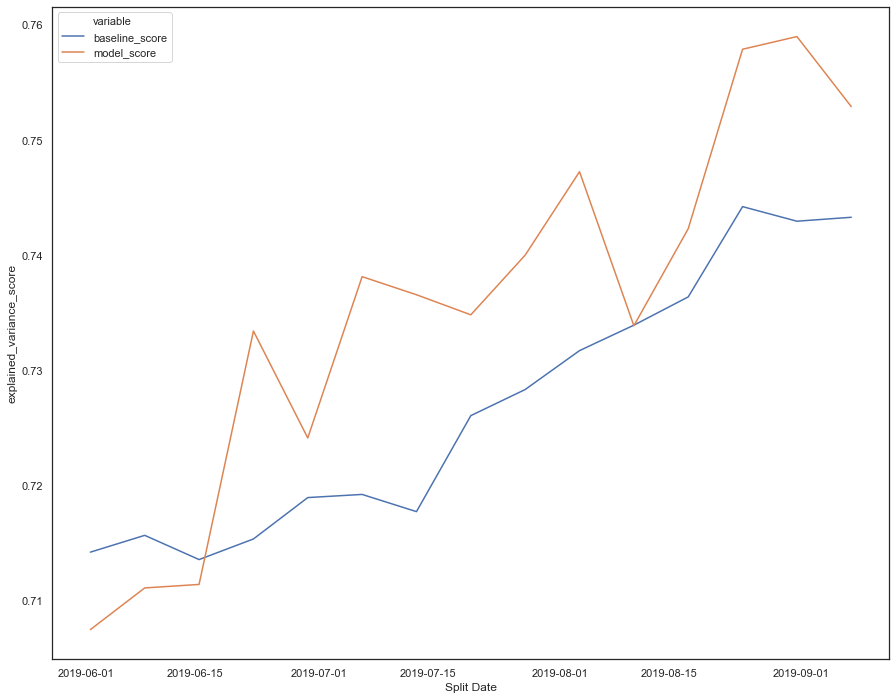

In [77]:
benchmarker(data_set = df_gold,model = RandomForestRegressor(),
            model_evaluator = 'explained_variance_score',variable_set = model_columns)

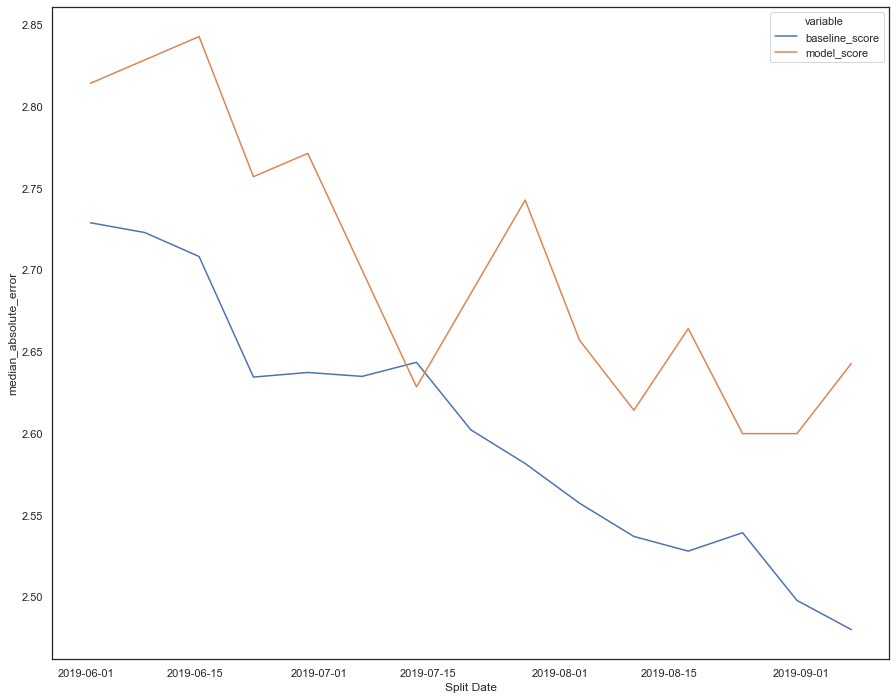

In [78]:
benchmarker(data_set = df_gold,model = RandomForestRegressor(),
            model_evaluator = 'median_absolute_error',variable_set = model_columns)

#### Binary Outcome Comparison Against Benchmark

In [79]:
#binarizing next week's sleep score: 0 if decrease, 1 otherwise
df_gold['avg_sleep_score_next_week_binarized'] = (df_gold['avg_sleep_score_next_week'] >= df_gold['rol_sleep_score_7d']).astype(int)

In [91]:
model_columns = ['summary_date','rol_sleep_score_7d','rol_sleep_afterMidnight_7d','rol_onset_latency_7d','rol_duration_7d',
                 'rol_score_disturbances_7d','rol_bedtime_start_delta_7d','rol_cal_total_7d','rol_steps_7d',
                 'rol_met_min_medium_plus_7d','rol_score_move_every_hour_7d', 'rol_score_stay_active_7d', 
                 'rol_beforesleep_exercise_min_7d', 'rol_afterwake_exercise_min_7d','rol_is_traveling_7d',
                 'score_training_frequency', 'score_training_volume','score_meet_daily_targets',
                 'temperature_deviation','is_male','is_workday','avg_sleep_score_next_week',
                 'activity_routine_score','sleep_routine_score','user_id','avg_sleep_score_next_week_binarized']

In [92]:
logistic_model = make_pipeline(StandardScaler(),
                        LogisticRegression(solver='lbfgs', multi_class='ovr'))


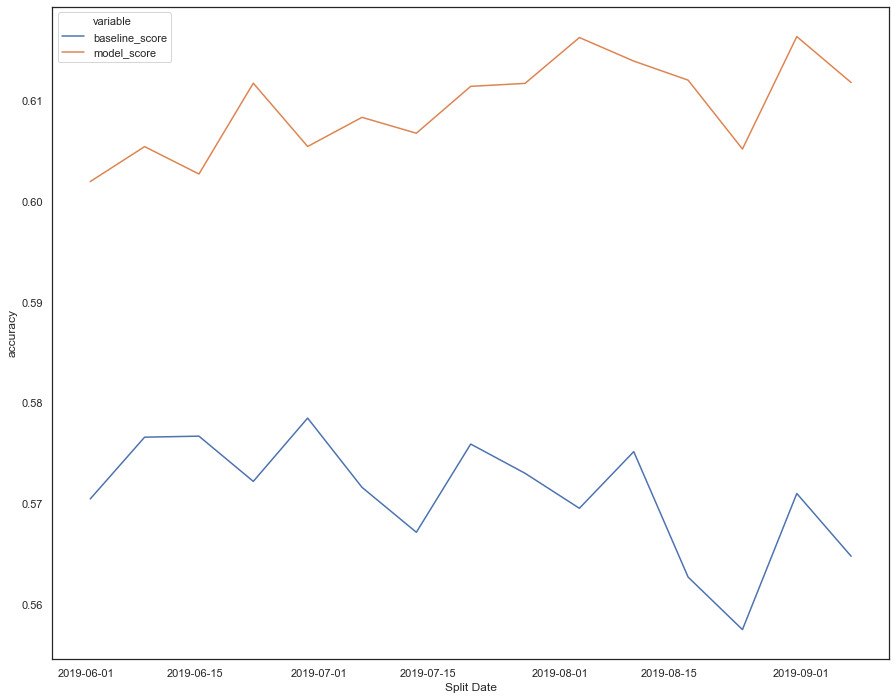

In [95]:
benchmarker(data_set = df_gold,model = logistic_model, outcome = 'avg_sleep_score_next_week_binarized',
            model_evaluator = 'accuracy',variable_set = model_columns)

In [84]:
#dataset balance
sum(df_gold['avg_sleep_score_next_week_binarized'])/df_gold.shape[0]

0.4178562883802536